<a href="https://colab.research.google.com/github/AtharvaGh/StartingOne/blob/main/Usecase1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [229]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [230]:
import pandas as pd
import numpy as np
from scipy import stats
from keras.layers import Dense,Flatten
from keras.models import sequential
from sklearn import preprocessing
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns

In [231]:
def load_data(path):
  auto = pd.read_csv(path)
  print("Rows:",auto.shape[0],"Columns:",auto.shape[1])
  return(auto)
auto = load_data("/content/drive/MyDrive/Datasets/Train.csv")
auto.head(10)

Rows: 8068 Columns: 11


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A
5,461319,Male,Yes,56,No,Artist,0.0,Average,2.0,Cat_6,C
6,460156,Male,No,32,Yes,Healthcare,1.0,Low,3.0,Cat_6,C
7,464347,Female,No,33,Yes,Healthcare,1.0,Low,3.0,Cat_6,D
8,465015,Female,Yes,61,Yes,Engineer,0.0,Low,3.0,Cat_7,D
9,465176,Female,Yes,55,Yes,Artist,1.0,Average,4.0,Cat_6,C


Removing ID as it is not needed for analysis

In [232]:
auto = auto.drop(['ID'],axis=1)

In [233]:
auto.shape

(8068, 10)

Dealing with null values

In [234]:
auto.isnull().sum()

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

Using select data types to get the numeric columns so i can pass them to a function that replaces null values with their median

In [235]:
def mean_replace(df,columns):
  for c in columns:
    if df[c].isnull().sum()>0:
      df[c].fillna(value=auto[c].median(),inplace = True)
      print(c,":",df[c].isnull().sum())
  return(df)
columns = auto.select_dtypes(include=[np.number]).columns
auto = mean_replace(auto,columns)


Work_Experience : 0
Family_Size : 0


Using select data types to get the non-numeric columns so i can pass them to a function that replaces null values with their modes. This is fine in this dataset as all the non-numeric columns in the dataset are categorical in functionality


In [236]:
def mode_replace(df,columns):
  for c in columns:
    if df[c].isna().sum()>0:
      df[c].fillna(value=auto[c].mode()[0],inplace = True)
      print(c,":",df[c].isnull().sum())
  return(df)
columns = auto.select_dtypes(include='object').columns
auto = mode_replace(auto,columns)

Ever_Married : 0
Graduated : 0
Profession : 0
Var_1 : 0


In [237]:
auto.Profession.value_counts()

Artist           2640
Healthcare       1332
Entertainment     949
Engineer          699
Doctor            688
Lawyer            623
Executive         599
Marketing         292
Homemaker         246
Name: Profession, dtype: int64

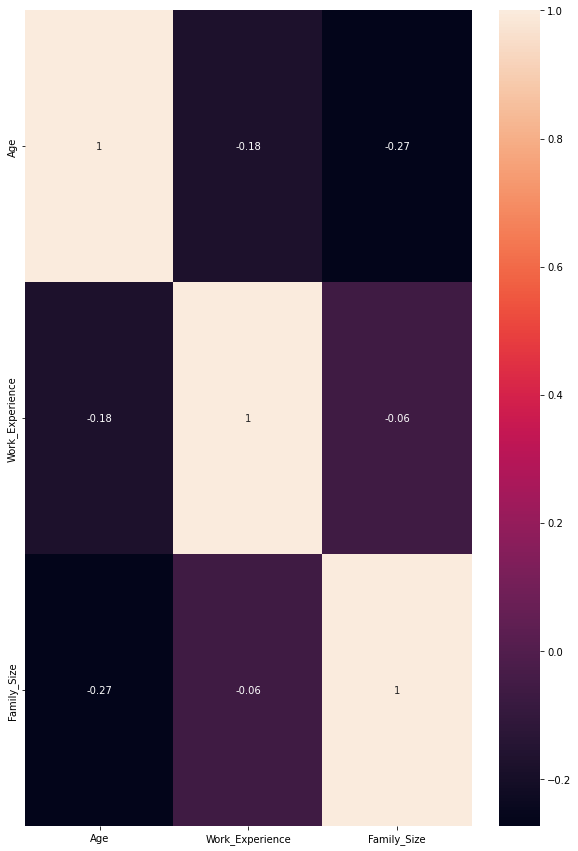

In [238]:
plt.figure(figsize=(10,15))
auto_corr = auto.corr()
sns.heatmap(auto_corr,annot=True)

In [239]:
auto.isnull().sum()

Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64

In [240]:
auto.shape

(8068, 10)

## Outlier detection

In [241]:
def z_score(df,columns):
  for c in columns:
    z = np.abs(stats.zscore(auto[c]))
    outliers = np.where(z>3)
    df.drop(outliers[0], inplace = True)
    print("Outliers for ",c,outliers[0],"have been removed")
  return(df)
columns = auto.select_dtypes(include=[np.number]).columns
auto = z_score(auto,columns)


Outliers for  Age [] have been removed
Outliers for  Work_Experience [  22   42   55  321  338  391  455  517  531  628  831  842  857  992
 1226 1232 1264 1549 1695 2025 2059 2193 2226 2258 2259 2267 2296 2388
 2421 2431 2722 2729 2792 2822 2837 3044 3055 3131 3177 3178 3243 3264
 3298 3757 3765 3767 3879 3902 3910 3979 4225 4312 4465 4685 4773 4784
 4869 4961 4978 5096 5313 5395 5492 5530 5531 5684 5728 5825 5992 5994
 6003 6039 6101 6158 6237 6518 6555 6730 6780 6793 6992 7205 7386 7397
 7663 7726 7798 7835 7990 8028 8043] have been removed
Outliers for  Family_Size [  25  147  199  289  339  708  856  927 1020 1280 1386 1430 1492 1529
 1585 1710 1883 1923 2286 2373 2436 2481 2538 2579 2617 2680 2686 2761
 2930 3000 3195 3318 3459 3463 3561 3563 3662 3671 3719 3848 3909 4198
 4372 4395 4427 4549 4577 4580 4644 4755 4891 4899 5019 5220 5307 5350
 5356 5493 5516 5615 5695 5989 6026 6196 6228 6258 6276 6295 6317 6526
 6547 6550 6572 6677 6799 6814 6829 6931 6966 7188 7265 7333 7413 745

In [242]:
mapp = [{'col':'Spending_Score','mapping':{'Low':1,'Average':2,'High':3}}]
encoder = ce.OrdinalEncoder(mapping = mapp, return_df = True)  
auto = encoder.fit_transform(auto)

## Binning

In [243]:
bins = [0,20,40,60,80,100]
auto['Age_range'] = pd.cut(auto['Age'],bins)


In [244]:
#l_en = preprocessing.LabelEncoder()
#auto['Profession']= l_en.fit_transform(auto['Profession'])



In [245]:
#l_en.classes_

In [246]:
dic = {'a':[3,53,5,3,3],'b':[324,245,2,45,4]}
dic['a'].append(3)
dic['a']

[3, 53, 5, 3, 3, 3]

Label Encoding

In [247]:
classes = []
def labening(df,columns):
  classlabel = []
  l_en = preprocessing.LabelEncoder()
  df[columns]= l_en.fit_transform(auto[columns])
  print(l_en.classes_)
  return(df,l_en.classes_)
  
auto,c = labening(auto,'Var_1')
classes.append(c)

['Cat_1' 'Cat_2' 'Cat_3' 'Cat_4' 'Cat_5' 'Cat_6' 'Cat_7']


In [248]:
classes

[array(['Cat_1', 'Cat_2', 'Cat_3', 'Cat_4', 'Cat_5', 'Cat_6', 'Cat_7'],
       dtype=object)]

In [249]:
auto.head(5)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Age_range
0,Male,No,22,No,Healthcare,1.0,1,4.0,3,D,"(20, 40]"
1,Female,Yes,38,Yes,Engineer,1.0,2,3.0,3,A,"(20, 40]"
2,Female,Yes,67,Yes,Engineer,1.0,1,1.0,5,B,"(60, 80]"
3,Male,Yes,67,Yes,Lawyer,0.0,3,2.0,5,B,"(60, 80]"
4,Female,Yes,40,Yes,Entertainment,1.0,3,6.0,5,A,"(20, 40]"


In [250]:
def onehotencoding(df,columns):
  from sklearn.preprocessing import OneHotEncoder
  one_en = OneHotEncoder(sparse=False)
  for c in columns:
    df[c] = one_en.fit_transform(df[[c]])
  return(df)
columns = auto.select_dtypes(include='object').columns
columns = list(columns)
columns.remove('Segmentation')
columns.remove('Profession')
auto = onehotencoding(auto,columns)

In [251]:
auto.head(10)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Age_range
0,0.0,1.0,22,1.0,Healthcare,1.0,1,4.0,3,D,"(20, 40]"
1,1.0,0.0,38,0.0,Engineer,1.0,2,3.0,3,A,"(20, 40]"
2,1.0,0.0,67,0.0,Engineer,1.0,1,1.0,5,B,"(60, 80]"
3,0.0,0.0,67,0.0,Lawyer,0.0,3,2.0,5,B,"(60, 80]"
4,1.0,0.0,40,0.0,Entertainment,1.0,3,6.0,5,A,"(20, 40]"
5,0.0,0.0,56,1.0,Artist,0.0,2,2.0,5,C,"(40, 60]"
6,0.0,1.0,32,0.0,Healthcare,1.0,1,3.0,5,C,"(20, 40]"
7,1.0,1.0,33,0.0,Healthcare,1.0,1,3.0,5,D,"(20, 40]"
8,1.0,0.0,61,0.0,Engineer,0.0,1,3.0,6,D,"(60, 80]"
9,1.0,0.0,55,0.0,Artist,1.0,2,4.0,5,C,"(40, 60]"


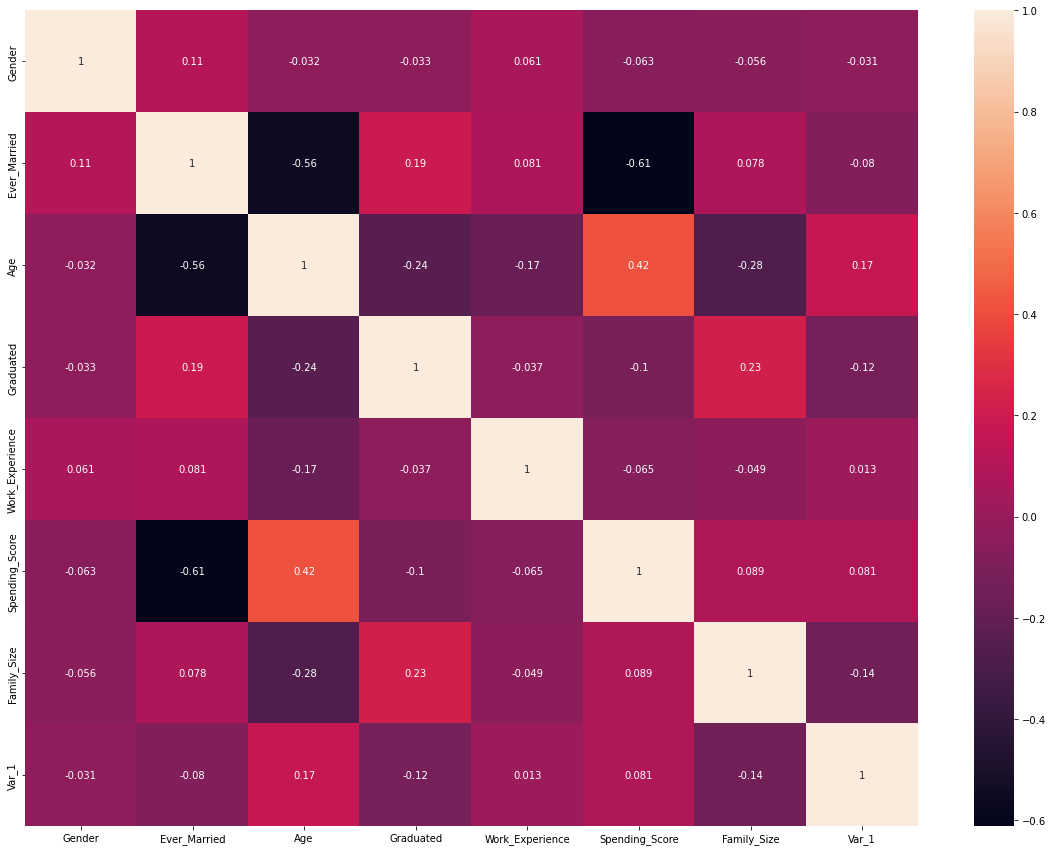

In [252]:
plt.figure(figsize=(20,15))
auto_corr = auto.corr()
sns.heatmap(auto_corr,annot=True)

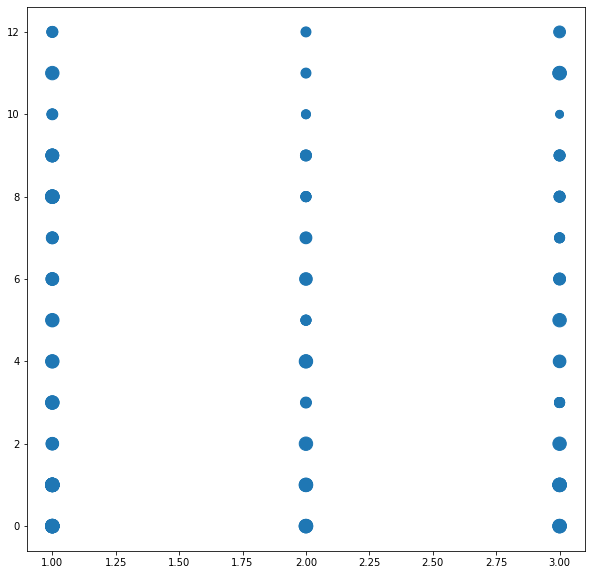

In [253]:
#Question 1 How is Spending ammount affected by work_experience and family size
plt.figure(figsize=(10,10))
plt.scatter(auto['Spending_Score'],auto['Work_Experience'],s=auto['Family_Size']*20)
plt.show()

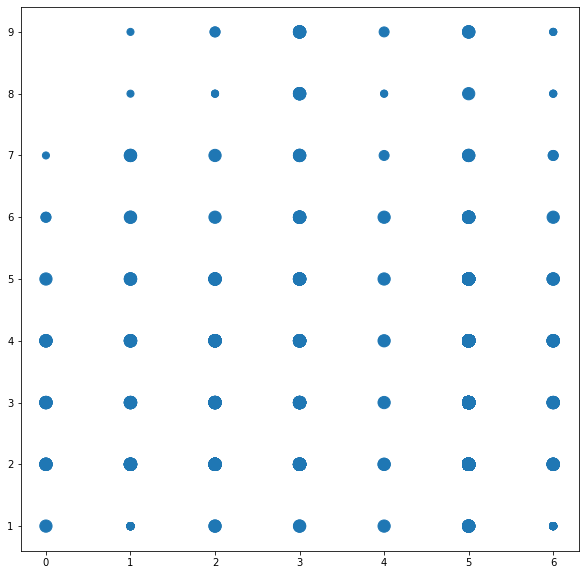

In [254]:
# Depending on the category of the product, does spending increase with family size
plt.figure(figsize=(10,10))
plt.scatter(auto['Var_1'],auto['Family_Size'],s=auto['Spending_Score']*50)
plt.show()

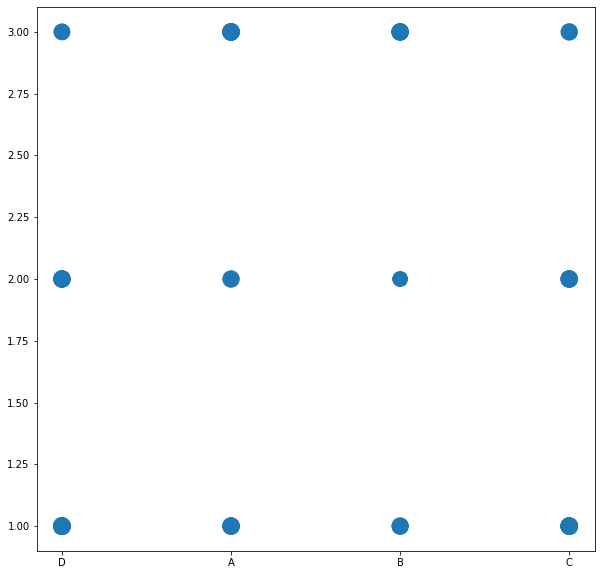

In [255]:
#In a Segement, does spending increase with family size
plt.figure(figsize=(10,10))
plt.scatter(auto['Segmentation'],auto['Spending_Score'],s=auto['Family_Size']*30)
plt.show()

[Text(0.5, 1.0, 'Which segemnts have individuals with low spending')]

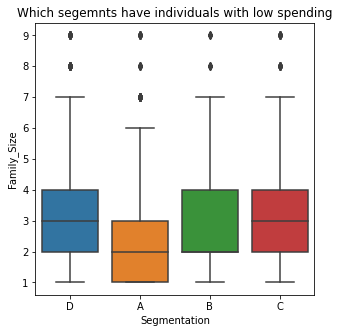

In [256]:
#Which segemnts have individuals with low spending?
plt.figure(figsize=(5,5))
sns.boxplot(x='Segmentation',y='Family_Size',data=auto).set(title='Which segemnts have individuals with low spending')

[Text(0.5, 1.0, 'Which Age range have greater number of graduates')]

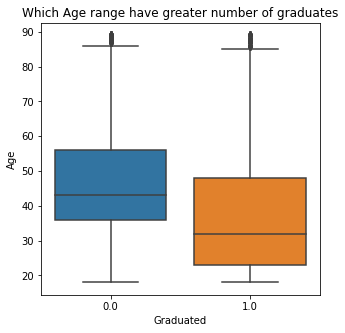

In [257]:
#Which Age range have greater number of graduates?
plt.figure(figsize=(5,5))
sns.boxplot(x='Graduated',y='Age',data=auto).set(title='Which Age range have greater number of graduates')

[Text(0.5, 1.0, 'For family sizes between 2-4 what is the average spending by profession')]

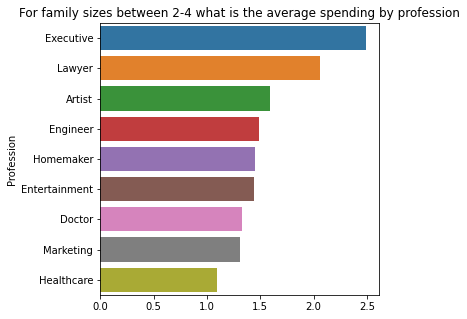

In [258]:
#Which profession has highest work experience
fam = np.where((auto['Family_Size'] <= 4))
auto2 = auto[auto.index.isin(fam[0])]
auto_sum = auto2.groupby(by="Profession")['Spending_Score'].mean()
auto_sum.sort_values(ascending=False,inplace=True)

plt.figure(figsize=(5,5))
sns.barplot(y=auto_sum.keys(),x=auto_sum.values).set(title="For family sizes between 2-4 what is the average spending by profession")

[Text(0.5, 1.0, 'Which segment has the highest Spending score?')]

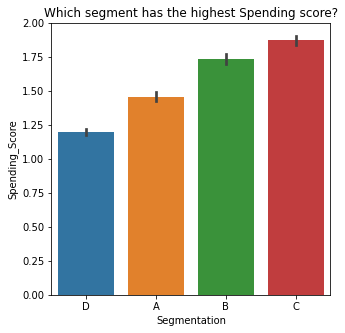

In [259]:
#Which segment has the highest Spending score

plt.figure(figsize=(5,5))
sns.barplot(y=auto['Spending_Score'],x=auto['Segmentation']).set(title = "Which segment has the highest Spending score?")

<Figure size 360x360 with 0 Axes>

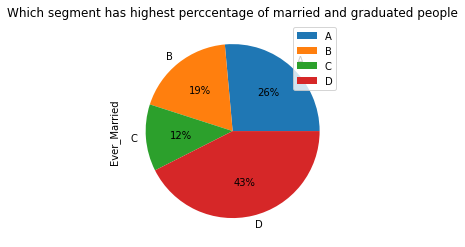

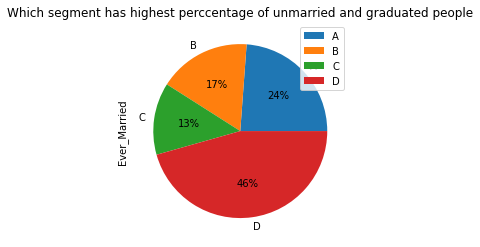

In [260]:
#Which segment has highest perccentage of married and graduated people
plt.figure(figsize=(5,5))
married_yes = np.where((auto['Ever_Married'] == 1.0) & (auto['Graduated'] == 1.0))
married_no = np.where((auto['Ever_Married'] == 0.0) & (auto['Graduated'] == 1.0))
pie1 = auto[auto.index.isin(married_yes[0])]
pie2 = auto[auto.index.isin(married_no[0])]
pie1.groupby(['Segmentation']).mean().plot(kind='pie', y='Ever_Married',autopct='%1.0f%%',title="Which segment has highest perccentage of married and graduated people")
pie2.groupby(['Segmentation']).mean().plot(kind='pie', y='Ever_Married',autopct='%1.0f%%',title="Which segment has highest perccentage of unmarried and graduated people")

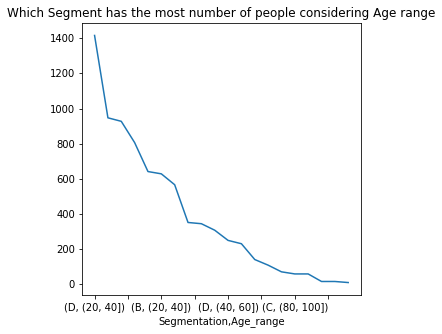

In [261]:
#Which Segment has the most number of people considering Age range
plt.figure(figsize=(5,5))
auto[["Segmentation","Age_range"]].value_counts(sort = True).plot(kind="line",title="Which Segment has the most number of people considering Age range")

## Feature Engineering


In [262]:
auto.head(5)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Age_range
0,0.0,1.0,22,1.0,Healthcare,1.0,1,4.0,3,D,"(20, 40]"
1,1.0,0.0,38,0.0,Engineer,1.0,2,3.0,3,A,"(20, 40]"
2,1.0,0.0,67,0.0,Engineer,1.0,1,1.0,5,B,"(60, 80]"
3,0.0,0.0,67,0.0,Lawyer,0.0,3,2.0,5,B,"(60, 80]"
4,1.0,0.0,40,0.0,Entertainment,1.0,3,6.0,5,A,"(20, 40]"


In [263]:
auto,c = labening(auto,'Age_range')
classes.append(c)

[Interval(0, 20, closed='right') Interval(20, 40, closed='right')
 Interval(40, 60, closed='right') Interval(60, 80, closed='right')
 Interval(80, 100, closed='right')]


In [264]:
classes

[array(['Cat_1', 'Cat_2', 'Cat_3', 'Cat_4', 'Cat_5', 'Cat_6', 'Cat_7'],
       dtype=object),
 array([Interval(0, 20, closed='right'), Interval(20, 40, closed='right'),
        Interval(40, 60, closed='right'), Interval(60, 80, closed='right'),
        Interval(80, 100, closed='right')], dtype=object)]

In [265]:
def getdum(df,c):
  one_hot_encoded_data = pd.get_dummies(df, columns = c)
  return(one_hot_encoded_data)
d = getdum(auto,['Profession'])

In [266]:
d2 = getdum(d,['Var_1'])

In [267]:
d3 = getdum(d2,['Segmentation'])

In [268]:
d2

,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Segmentation,Age_range,Profession_Artist,...,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Var_1_0,Var_1_1,Var_1_2,Var_1_3,Var_1_4,Var_1_5,Var_1_6
0,0.0,1.0,22,1.0,1.0,1,4.0,D,1,0,...,0,0,0,0,0,0,1,0,0,0
1,1.0,0.0,38,0.0,1.0,2,3.0,A,1,0,...,0,0,0,0,0,0,1,0,0,0
2,1.0,0.0,67,0.0,1.0,1,1.0,B,3,0,...,0,0,0,0,0,0,0,0,1,0
3,0.0,0.0,67,0.0,0.0,3,2.0,B,3,0,...,0,1,0,0,0,0,0,0,1,0
4,1.0,0.0,40,0.0,1.0,3,6.0,A,1,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8063,0.0,1.0,22,1.0,0.0,1,7.0,D,1,1,...,0,0,0,1,0,0,0,0,0,0
8064,0.0,1.0,35,1.0,3.0,1,4.0,D,1,0,...,0,0,0,0,0,0,1,0,0,0
8065,1.0,1.0,33,0.0,1.0,1,1.0,D,1,0,...,0,0,0,0,0,0,0,0,1,0
8066,1.0,1.0,27,0.0,1.0,1,4.0,B,1,0,...,0,0,0,0,0,0,0,0,1,0


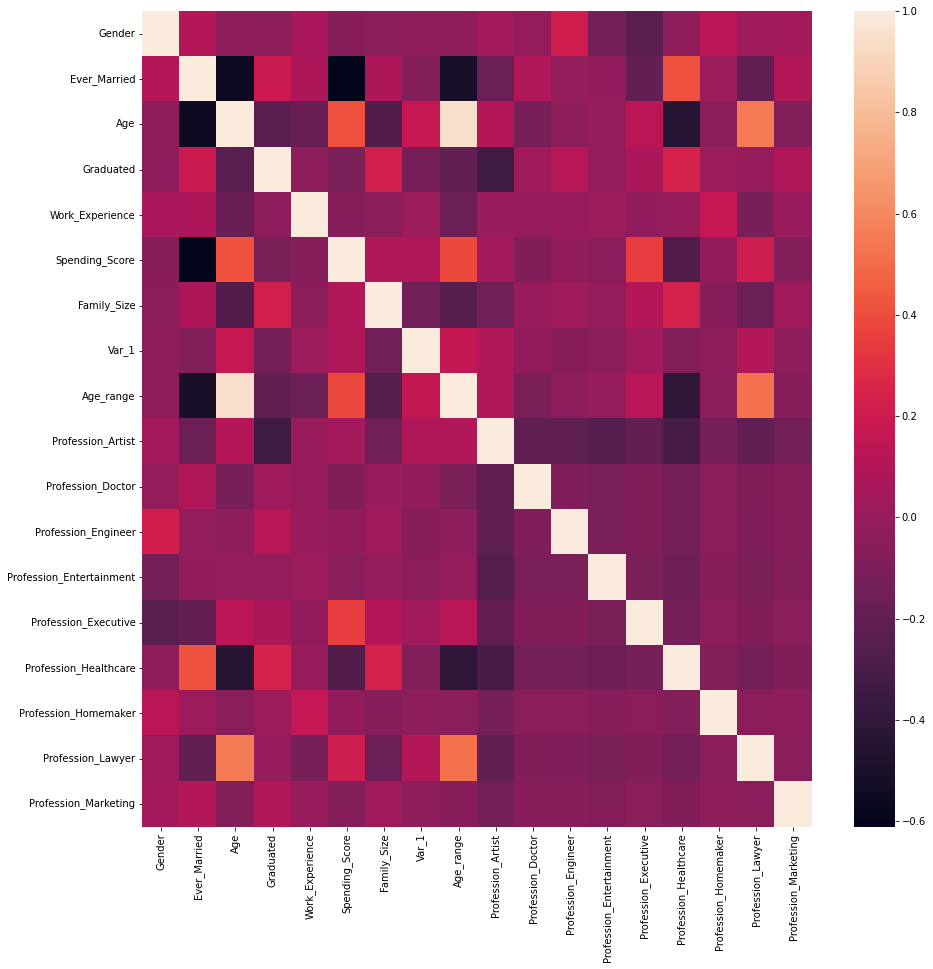

In [269]:
plt.figure(figsize=(15,15))
auto_corr = d.corr()
sns.heatmap(auto_corr)

In [270]:
auto.drop(columns = 'Age',axis=0,inplace=True)

In [271]:
d3.iloc[1:5,-4:]

,Segmentation_A,Segmentation_B,Segmentation_C,Segmentation_D
1,1,0,0,0
2,0,1,0,0
3,0,1,0,0
4,1,0,0,0


In [278]:
X = d3.iloc[:,:-4]
Y = d3.iloc[:,-4:]

In [279]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=5)

In [280]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [281]:
X_df = pd.DataFrame(X_train,columns=X.columns)

In [282]:
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((6308, 24), (1577, 24), (6308, 4), (1577, 4))

In [179]:
#from tensorflow.keras.utils import to_categorical
#Y_train = to_categorical(Y_train, 4)
#Y_test = to_categorical(Y_test, 4)

In [292]:
X_train.shape

(6308, 24)

In [181]:
X_df.dtypes

Gender                      float64
Ever_Married                float64
Age                         float64
Graduated                   float64
Work_Experience             float64
Spending_Score              float64
Family_Size                 float64
Var_1                       float64
Age_range                   float64
Profession_Artist           float64
Profession_Doctor           float64
Profession_Engineer         float64
Profession_Entertainment    float64
Profession_Executive        float64
Profession_Healthcare       float64
Profession_Homemaker        float64
Profession_Lawyer           float64
Profession_Marketing        float64
dtype: object

## Modeling

In [287]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, LeakyReLU, BatchNormalization, Dropout
from keras.activations import relu, sigmoid

In [288]:
def create_model(layers, activation):
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i==0:
            model.add(Dense(nodes,input_dim=X_train.shape[1]))
            model.add(Activation(activation))
        else:
            model.add(Dense(nodes))
            model.add(Activation(activation))
    model.add(Dense(4)) # Note: no activation beyond this point
    
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    return model
    
model = KerasClassifier(build_fn=create_model, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  from ipykernel import kernelapp as app


In [289]:
layers = [[20], [40, 20], [45, 30, 15]]
activations = ['softmax','sigmoid', 'relu']
param_grid = dict(layers=layers, activation=activations, batch_size = [128, 256], epochs=[30])
grid = GridSearchCV(estimator=model, param_grid=param_grid)

In [290]:
grid_result = grid.fit(X_train, Y_train)

In [293]:
[grid_result.best_score_,grid_result.best_params_]

[0.3876252233982086,
 {'activation': 'relu',
  'batch_size': 128,
  'epochs': 30,
  'layers': [45, 30, 15]}]

In [187]:
#Y_pred = grid.predict(X_test)

In [219]:
#from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(Y_test, Y_pred)

In [ ]:
#cm

In [ ]:
#from sklearn.metrics import accuracy_score
#score=accuracy_score(Y_test,Y_pred)

In [ ]:
#score

In [ ]:
#df = pd.DataFrame(grid_result.cv_results_)
#df

In [346]:
model = Sequential()
model.add(Dense(45,input_dim=24,activation='relu'))
model.add(Dense(30,activation='relu'))
model.add(Dense(15,activation='relu'))
model.add(Dense(4,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [347]:
model.fit(X_train,Y_train,epochs=3500,batch_size=128,verbose=1)

Streaming output truncated to the last 5000 lines.
50/50 [==============================] - 0s 4ms/step - loss: 0.6332 - accuracy: 0.7354
Epoch 1002/3500
50/50 [==============================] - 0s 4ms/step - loss: 0.6365 - accuracy: 0.7316
Epoch 1003/3500
50/50 [==============================] - 0s 4ms/step - loss: 0.6281 - accuracy: 0.7376
Epoch 1004/3500
50/50 [==============================] - 0s 4ms/step - loss: 0.6339 - accuracy: 0.7335
Epoch 1005/3500
50/50 [==============================] - 0s 4ms/step - loss: 0.6357 - accuracy: 0.7353
Epoch 1006/3500
50/50 [==============================] - 0s 4ms/step - loss: 0.6307 - accuracy: 0.7329
Epoch 1007/3500
50/50 [==============================] - 0s 4ms/step - loss: 0.6283 - accuracy: 0.7364
Epoch 1008/3500
50/50 [==============================] - 0s 4ms/step - loss: 0.6311 - accuracy: 0.7380
Epoch 1009/3500
50/50 [==============================] - 0s 4ms/step - loss: 0.6380 - accuracy: 0.7302
Epoch 1010/3500
50/50 [===============

In [348]:
y_pred = model.predict(X_test)

In [349]:
y_pred

array([[5.9859514e-01, 3.5850327e-03, 1.7904892e-03, 3.9602929e-01],
       [1.4695103e-03, 3.4953371e-01, 6.4780045e-01, 1.1964552e-03],
       [9.4503915e-01, 5.4948155e-02, 8.9759742e-06, 3.7129073e-06],
       ...,
       [6.3250229e-02, 7.3856395e-01, 1.8315671e-01, 1.5029025e-02],
       [6.6412950e-01, 5.6741901e-02, 1.1158665e-04, 2.7901700e-01],
       [4.7985296e-08, 3.3119799e-11, 1.3819963e-21, 1.0000000e+00]],
      dtype=float32)

In [350]:
from sklearn.metrics import confusion_matrix
Y_pred=np.argmax(y_pred, axis=1)
Y_test_r=np.argmax(Y_test.values, axis=1)
cm = confusion_matrix(Y_test_r, Y_pred)
print(cm)

[[142  99  53  69]
 [124 117 113  37]
 [ 70  87 182  45]
 [ 98  47  37 257]]


In [351]:
cm_df = pd.DataFrame(cm,index = ['A','B','C','D'], columns = ['A','B','C','D'])

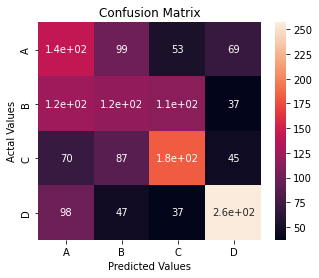

In [352]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()